# Fusion of Video and IMU Features
## With Time Shifting
## Training on Synchronized Video and Shifted IMU Data

## Video and IMU data is concatenated at an intermediate layer and then prediction is made

In [1]:
import numpy as np
import scipy.io

# random seed.
rand_seed = 1

from numpy.random import seed
from numpy import random

seed(rand_seed)
from tqdm.keras import TqdmCallback
import tensorflow
tensorflow.random.set_seed(rand_seed)

import keras
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, LSTM, Dense, Dropout, Flatten, Activation, BatchNormalization, GlobalAveragePooling3D, TimeDistributed, ConvLSTM2D
from keras.layers.core import Permute, Reshape
from keras import backend as K


In [2]:
def one_hot_encoding(y_data):
    Mapping=dict()
    sub_dirs=['downstair','upstair','run','jump','walk','handwashing','exercise']

    categories=10


    count=0
    for i in sub_dirs:
        Mapping[i]=count
        count=count+1

    y_features2=[]
    for i in range(len(y_data)):
        Type=y_data[i]
        lab=Mapping[Type]
        y_features2.append(lab)

    y_features=np.array(y_features2)
    y_features=y_features.reshape(y_features.shape[0],1)
    from keras.utils import to_categorical
    y_features = to_categorical(y_features)

    return y_features

In [3]:
path='C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/data/'

def get_train_and_validate_data(path=path):
    Train_data = np.load(path+'Data_train_all.npz')
    Labels = Train_data['arr_1']
    Features_imu = np.asarray(Train_data['arr_0'],dtype=np.float64)
    Features_video = Train_data['arr_3']

    Labels = one_hot_encoding(Labels)
    
    randomize = np.arange(len(Labels))
    np.random.shuffle(randomize)
    
    Labels = Labels[randomize]
    Features_imu = Features_imu[randomize]
    Features_video = Features_video[randomize]
    
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 
    
    new_Labels = np.split(Labels,[Labels.shape[0] - 2000])
    new_Features_imu = np.split(Features_imu,[Features_imu.shape[0] - 2000])
    new_Features_video = np.split(Features_video,[Features_video.shape[0] - 2000])
    
    return new_Labels[0][:750],new_Features_imu[0][:750],new_Features_video[0][:750],new_Labels[1],new_Features_imu[1],new_Features_video[1]

def get_test_data(path=path):
    Train_data = np.load(path+'Data_test_71.pkl',allow_pickle=True)
    Labels = Train_data[1]
    Features_imu = np.asarray(Train_data[0],dtype=np.float64)
    Features_video = Train_data[3]
    
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 
    Labels = one_hot_encoding(Labels)

    return Labels,Features_imu,Features_video

In [4]:
Labels,Features_imu,Features_video,Labels2,Features_imu2,Features_video2 = get_train_and_validate_data()
print(Labels.shape,Features_imu.shape,Features_video.shape)
print('Train Classes distribution: ',np.sum(Labels, axis = 0))

print(Labels2.shape,Features_imu2.shape,Features_video2.shape)
print('Validate Classes distribution: ',np.sum(Labels2, axis = 0))

Labels3,Features_imu3,Features_video3 = get_test_data()
print(Labels3.shape,Features_imu3.shape,Features_video3.shape)
print('Test Classes distribution: ',np.sum(Labels3, axis = 0))

(750, 7) (750, 1, 40, 12) (750, 45, 64, 64, 3)
Train Classes distribution:  [107. 134.  96. 115.  78. 111. 109.]
(2000, 7) (2000, 1, 40, 12) (2000, 45, 64, 64, 3)
Validate Classes distribution:  [298. 390. 203. 315. 215. 289. 290.]
(1377, 7) (1377, 1, 40, 12) (1377, 45, 64, 64, 3)
Test Classes distribution:  [219. 268. 124. 146. 143. 234. 243.]


In [5]:
def get_shifted_data(file,path=path):
    Train_data = np.load(path+file)
    Labels = Train_data['arr_1']
    Features_imu = np.asarray(Train_data['arr_0'],dtype=np.float64)
    Features_video = Train_data['arr_3']
    
    return Labels,Features_imu,Features_video

In [6]:
shift_path='E:/augmented_data/'

for i in range(1,41):
    file='train_data_'+str(i)+'_shift.npz'

    shiftLabels,shiftFeatures_imu,shiftFeatures_video = get_shifted_data(file,shift_path)

    Labels = np.concatenate((Labels,shiftLabels),axis=0)
    Features_imu = np.concatenate((Features_imu,shiftFeatures_imu),axis=0)
    Features_video = np.concatenate((Features_video,shiftFeatures_video),axis=0)

print(Labels.shape,Features_imu.shape,Features_video.shape)

(30750, 7) (30750, 1, 40, 12) (30750, 45, 64, 64, 3)


# Combined Model: Video + IMU

In [7]:
def combined_video_imu_model():
    num_classes = 7
    num_feat_map=32
    _, dim, win_len, _, = Features_imu.shape
    input_imu = keras.layers.Input(shape=(dim, win_len, 12))

    I1 = keras.layers.Conv2D(num_feat_map, kernel_size=(1, 5), activation='relu', padding='same')(input_imu)
    I2 = keras.layers.MaxPooling2D(pool_size=(1, 2))(I1)

    I3 = keras.layers.Conv2D(num_feat_map, kernel_size=(1, 5), activation='relu', padding='same')(I2)
    I4 = keras.layers.MaxPooling2D(pool_size=(1, 2))(I3)
    I5 = keras.layers.Flatten()(I4)

    I6 = keras.layers.Dense(256, activation='relu')(I5)
    I7 = keras.layers.Dropout(0.3)(I6)

    input_video = keras.layers.Input(shape=(45, 64, 64, 3))
    V1 = keras.layers.Conv3D(32, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name='conv1', input_shape=(45, 64, 64, 3))(input_video)
    V2 = keras.layers.MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2), padding='valid', name='pool1')(V1)

    V3 = keras.layers.Conv3D(64, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name='conv2', input_shape=(45, 64, 64, 3))(V2)
    V4 = keras.layers.MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='valid', name='pool2')(V3)

    V5 = keras.layers.Conv3D(64, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name='conv3a')(V4)
    V6 = keras.layers.Conv3D(64, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name='conv3b')(V5)
    V7 = keras.layers.MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='valid', name='pool3')(V6)

    V8 = keras.layers.Conv3D(128, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name='conv4a')(V7)
    V9 = keras.layers.Conv3D(128, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name='conv4b')(V8)
    V10 = keras.layers.MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='valid', name='pool4')(V9)

    V11 = keras.layers.Flatten()(V10)
    V12 = keras.layers.Dense(1024, activation='relu', name='fc1')(V11)
    V13 = keras.layers.Dropout(0.5)(V12)

    V14 = keras.layers.Dense(1024, activation='relu', name='fc2')(V13)
    V15 = keras.layers.Dropout(0.5)(V14)


    # equivalent to added = keras.layers.add([x1, x2])
    C1 = keras.layers.concatenate([I6, V15], axis=-1)
    C2 = keras.layers.Dense(128, activation='relu', name='combined_fc')(C1)

    out = keras.layers.Dense(num_classes, activation='softmax')(C2)

    model = keras.models.Model(inputs=[input_imu, input_video], outputs=out)
    
    return model


In [8]:
combined_model = combined_video_imu_model()

In [9]:
combined_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 45, 64, 64,  0                                            
__________________________________________________________________________________________________
conv1 (Conv3D)                  (None, 45, 64, 64, 3 2624        input_2[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling3D)            (None, 45, 32, 32, 3 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv3D)                  (None, 45, 32, 32, 6 55360       pool1[0][0]                      
_______________________________________________________________________________________

In [10]:
model_path = 'C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models/imu_video_combined_model_shift_checkpoint'

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

checkpointer = ModelCheckpoint(filepath=model_path, verbose=1,monitor='val_accuracy' ,save_best_only=True, save_weights_only=False)
earlystopper = EarlyStopping(monitor='val_accuracy',patience=5)

In [11]:
batch_size = 64
epochs = 100
from keras import optimizers
from keras.optimizers import Adam

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
combined_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= adam,
              metrics=['accuracy'])

import time
start_time = time.time()

learning_hist = combined_model.fit([Features_imu,Features_video], Labels,
                    verbose=0,
                    epochs=epochs,
                    shuffle=True,
                    batch_size=batch_size,
                    callbacks=[checkpointer,earlystopper,TqdmCallback(verbose=2)],
                    validation_data=([Features_imu2,Features_video2], Labels2))

end_time = time.time()

print("---Time %s seconds ---" % (end_time - start_time))

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/481 [00:00<?, ?batch/s]


Epoch 00001: val_accuracy improved from -inf to 0.97350, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_video_combined_model_shift_checkpoint
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_video_combined_model_shift_checkpoint\assets


  0%|          | 0.00/481 [00:00<?, ?batch/s]


Epoch 00002: val_accuracy improved from 0.97350 to 0.97850, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_video_combined_model_shift_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_video_combined_model_shift_checkpoint\assets


  0%|          | 0.00/481 [00:00<?, ?batch/s]


Epoch 00003: val_accuracy improved from 0.97850 to 0.99300, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_video_combined_model_shift_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_video_combined_model_shift_checkpoint\assets


  0%|          | 0.00/481 [00:00<?, ?batch/s]


Epoch 00004: val_accuracy improved from 0.99300 to 0.99350, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_video_combined_model_shift_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_video_combined_model_shift_checkpoint\assets


  0%|          | 0.00/481 [00:00<?, ?batch/s]


Epoch 00005: val_accuracy improved from 0.99350 to 0.99650, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_video_combined_model_shift_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_video_combined_model_shift_checkpoint\assets


  0%|          | 0.00/481 [00:00<?, ?batch/s]


Epoch 00006: val_accuracy did not improve from 0.99650


  0%|          | 0.00/481 [00:00<?, ?batch/s]


Epoch 00007: val_accuracy did not improve from 0.99650


  0%|          | 0.00/481 [00:00<?, ?batch/s]


Epoch 00008: val_accuracy improved from 0.99650 to 0.99850, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_video_combined_model_shift_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_video_combined_model_shift_checkpoint\assets


  0%|          | 0.00/481 [00:00<?, ?batch/s]


Epoch 00009: val_accuracy did not improve from 0.99850


  0%|          | 0.00/481 [00:00<?, ?batch/s]


Epoch 00010: val_accuracy did not improve from 0.99850


  0%|          | 0.00/481 [00:00<?, ?batch/s]


Epoch 00011: val_accuracy did not improve from 0.99850


  0%|          | 0.00/481 [00:00<?, ?batch/s]


Epoch 00012: val_accuracy did not improve from 0.99850


  0%|          | 0.00/481 [00:00<?, ?batch/s]


Epoch 00013: val_accuracy did not improve from 0.99850
---Time 3183.227243423462 seconds ---


# Accuracies

In [12]:
from keras.models import load_model

model_path2 = 'C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models/imu_video_combined_model_checkpoint'

model = load_model(model_path)
model2 = load_model(model_path2)

In [13]:
#Train Accuracy
model.evaluate([Features_imu,Features_video],Labels,batch_size=64)
model2.evaluate([Features_imu,Features_video],Labels,batch_size=64)

481/481 [==============================] - 90s 187ms/step - loss: 0.6212 - accuracy: 0.9473


[0.6212106943130493, 0.9473496079444885]

In [14]:
## Valid Accuracy
model.evaluate([Features_imu2,Features_video2],Labels2,batch_size=64)
model2.evaluate([Features_imu2,Features_video2],Labels2,batch_size=64)

32/32 [==============================] - 6s 176ms/step - loss: 0.0505 - accuracy: 0.9915


[0.050524331629276276, 0.9915000200271606]

In [15]:
## Test Accuracy
model.evaluate([Features_imu3,Features_video3],Labels3,batch_size=64)
model2.evaluate([Features_imu3,Features_video3],Labels3,batch_size=64)

22/22 [==============================] - 4s 172ms/step - loss: 0.1046 - accuracy: 0.9717


[0.1046251580119133, 0.9716775417327881]

# Plotting

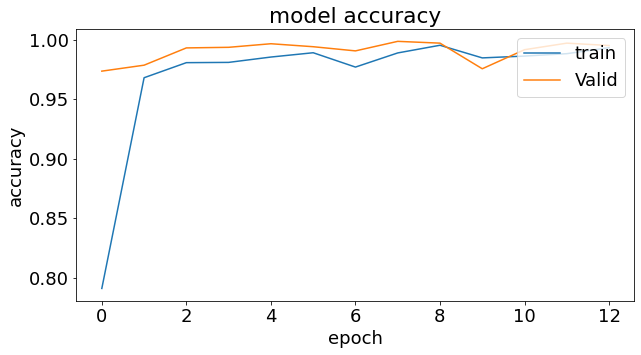

In [16]:
from matplotlib import pyplot as plt

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,5))

plt.plot(learning_hist.history['accuracy'])
plt.plot(learning_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()

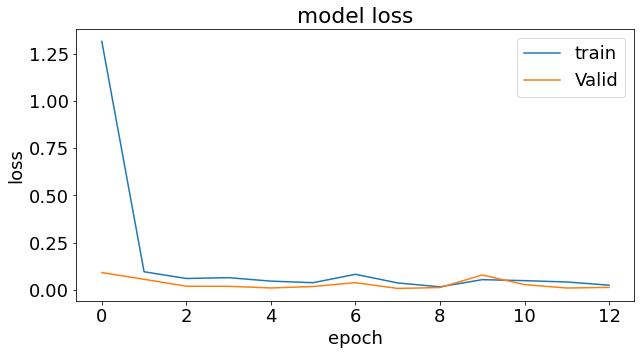

In [17]:
# summarize history for loss

from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 18})


plt.plot(learning_hist.history['loss'])
plt.plot(learning_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()

In [18]:
def get_test_data2(path=path):
    Train_data=np.load(path+'Data_test_71.pkl',allow_pickle=True)
    Features_imu=np.asarray(Train_data[0],dtype=np.float64)
    Labels=Train_data[1]
    Features_video=Train_data[3]
    
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_video

In [19]:
Features_imu_t1,Labels_t1,Features_video_t1 = get_test_data2()

In [20]:
Labels_t1 = np.array(Labels_t1)

In [21]:
Labels_t1[:100]

array(['downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'down

In [22]:
# For 10 second together
num_windows_together = 5

curr_indx = 0
final_indx = Features_imu_t1.shape[0]

data_together = []

while curr_indx <= final_indx:
    IMU_together   = Features_imu_t1[curr_indx:curr_indx+num_windows_together]
    video_together = Features_video_t1[curr_indx:curr_indx+num_windows_together]
    labels_together = Labels_t1[curr_indx:curr_indx+num_windows_together]
    
    data_together.append([IMU_together,video_together,labels_together])
    
    curr_indx = curr_indx+num_windows_together

In [23]:
rand_seed = 4
from numpy.random import seed
seed(rand_seed)

ordering = np.arange(len(data_together))
np.random.shuffle(ordering)

In [24]:
ordering[:100]

array([166, 225, 146, 215,  82,  46,  18, 113, 253,  47, 171, 275,   6,
       123, 250, 232, 203, 124,  45, 133, 111,  24,   1, 159, 212, 101,
       137, 128, 139, 256,  33,  11, 106,  68,  39,  69, 110,  43,  83,
       108, 169,  64, 223, 189, 134,  88, 235,  93, 191, 260, 249, 271,
       254, 100,  92,  71, 103,  63, 267, 144,  13,  42,  14, 268, 182,
       140,  84,  48, 130,  55, 184, 152, 251, 178,  20, 175, 129, 266,
       269, 218, 227, 193, 261,  91, 216, 162, 229, 116, 121,  34, 233,
       112, 247, 231, 239, 153,  57,  81,  70,  26])

In [25]:
indx = ordering[0]

Features_imu_t1  = data_together[indx][0]
Features_video_t1 = data_together[indx][1]
Labels_t1 = data_together[indx][2]


#print(Features_imu_t1.shape,Labels_t1.shape,Features_sound_t1.shape)

for i in range(1, len(data_together)):
    indx = ordering[i]
    IMU_together  = data_together[indx][0]
    video_together= data_together[indx][1]
    labels_together=data_together[indx][2]
    #print(indx, IMU_together.shape,sound_together.shape,labels_together.shape)
    Features_imu_t1 = np.concatenate((Features_imu_t1,IMU_together),axis=0)
    Labels_t1 = np.concatenate((Labels_t1,labels_together),axis=0)
    Features_video_t1 = np.concatenate((Features_video_t1,video_together),axis=0)
    #print(indx, IMU_together.shape,sound_together.shape,labels_together.shape)

In [26]:
print(Features_imu_t1.shape, Labels_t1.shape, Features_video_t1.shape)

(1377, 1, 40, 12) (1377,) (1377, 45, 64, 64, 3)


In [27]:
Labels_t1[:100]

array(['walk', 'walk', 'walk', 'walk', 'walk', 'handwashing',
       'handwashing', 'handwashing', 'handwashing', 'handwashing', 'jump',
       'jump', 'jump', 'jump', 'jump', 'handwashing', 'handwashing',
       'handwashing', 'handwashing', 'handwashing', 'upstair', 'upstair',
       'upstair', 'upstair', 'upstair', 'upstair', 'upstair', 'upstair',
       'upstair', 'upstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'run', 'run', 'run', 'run', 'run',
       'exercise', 'exercise', 'exercise', 'exercise', 'exercise',
       'upstair', 'upstair', 'upstair', 'upstair', 'upstair', 'walk',
       'walk', 'walk', 'walk', 'walk', 'exercise', 'exercise',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'jump', 'jump', 'jump', 'jump', 'jump', 'exercise', 'exercise',
       'exercise', 'exercise', 'exercise', 'exercise', 'exercise',
       'exercise', 'exercise', 'exercise', 'handwashing', 'handwashing',
       'handwashing', 'handw

In [28]:
Labels_t1 = one_hot_encoding(Labels_t1)

In [29]:
model.evaluate([Features_imu_t1,Features_video_t1],Labels_t1,batch_size=64)

22/22 [==============================] - 4s 174ms/step - loss: 0.0968 - accuracy: 0.9666


[0.0968121662735939, 0.9665940403938293]

In [30]:
acc_right=[]
gyro_right=[]
acc_left=[]
gyro_left=[]

for i in range(Features_imu_t1.shape[0]):
    acc_right.append([Features_imu_t1[i,0,:,0],Features_imu_t1[i,0,:,1],Features_imu_t1[i,0,:,2]])
    gyro_right.append([Features_imu_t1[i,0,:,3],Features_imu_t1[i,0,:,4],Features_imu_t1[i,0,:,5]])
    acc_left.append([Features_imu_t1[i,0,:,6],Features_imu_t1[i,0,:,7],Features_imu_t1[i,0,:,8]])
    gyro_left.append([Features_imu_t1[i,0,:,9],Features_imu_t1[i,0,:,10],Features_imu_t1[i,0,:,11]])
        

In [31]:
acc_right=np.array(acc_right)
gyro_right=np.array(gyro_right)
acc_left=np.array(acc_left)
gyro_left=np.array(gyro_left)

In [32]:
print(acc_right.shape)
print(gyro_right.shape)
print(acc_left.shape)
print(gyro_left.shape)

(1377, 3, 40)
(1377, 3, 40)
(1377, 3, 40)
(1377, 3, 40)


In [33]:
acc_right_cont= acc_right[0,]
gyro_right_cont= gyro_right[0,]

acc_left_cont= acc_left[0,]
gyro_left_cont= gyro_left[0,]


for i in range(1, Features_imu_t1.shape[0]):
    #print(i)
    acc_right_cont=np.hstack((acc_right_cont,acc_right[i,]))
    gyro_right_cont=np.hstack((gyro_right_cont,gyro_right[i,]))
    acc_left_cont=np.hstack((acc_left_cont,acc_left[i,]))
    gyro_left_cont=np.hstack((gyro_left_cont,gyro_left[i,]))

In [34]:
print(acc_right_cont.shape)
print(gyro_right_cont.shape)
print(acc_left_cont.shape)
print(gyro_left_cont.shape)


(3, 55080)
(3, 55080)
(3, 55080)
(3, 55080)


In [35]:
def get_data_sample_shift(shift_samples = 1):
    sample_size = 40 #need to be 40, as decided during training
    total_samples = acc_right_cont.shape[1]
    
    #print(total_samples)
    
    current_cursor = shift_samples

    i = 0

    acc_right_pro= np.array(acc_right_cont[np.newaxis,:,current_cursor:current_cursor+sample_size])

    #print(acc_right_pro.shape)

    gyro_right_pro= np.array(gyro_right_cont[np.newaxis,:,current_cursor:current_cursor+sample_size])

    acc_left_pro= np.array(acc_left_cont[np.newaxis,:,current_cursor:current_cursor+sample_size])

    gyro_left_pro= np.array(gyro_left_cont[np.newaxis,:,current_cursor:current_cursor+sample_size])

    #print(np.array(acc_right_cont[np.newaxis,:,current_cursor:current_cursor+sample_size]).shape)

    while current_cursor<=(total_samples-2*sample_size):
        current_cursor = current_cursor + sample_size
        #print(current_cursor," : ", i)
        a=acc_right_pro
        b=np.array(acc_right_cont[np.newaxis,:,current_cursor:current_cursor+sample_size])
        acc_right_pro = np.concatenate((a,b),axis=0)


        a=gyro_right_pro
        b=np.array(gyro_right_cont[np.newaxis,:,current_cursor:current_cursor+sample_size])
        gyro_right_pro = np.concatenate((a,b),axis=0)


        a=acc_left_pro
        b=np.array(acc_left_cont[np.newaxis,:,current_cursor:current_cursor+sample_size])
        #print(a.shape,b.shape)
        acc_left_pro = np.concatenate((a,b),axis=0)

        a=gyro_left_pro
        b=np.array(gyro_left_cont[np.newaxis,:,current_cursor:current_cursor+sample_size])
        gyro_left_pro = np.concatenate((a,b),axis=0)
        i = i+1
        
    IMU_processed = np.concatenate((acc_right_pro,gyro_right_pro,acc_left_pro,gyro_left_pro),axis=1)
    IMU_processed = IMU_processed[:,np.newaxis,:,:]
    IMU_processed = np.swapaxes(IMU_processed,2,3)
        
    size = IMU_processed.shape[0]
        
    return Features_video_t1[:size], IMU_processed ,Labels_t1[:size]
        

In [36]:
Accuracy_vanilla = []
Accuracy_1000ms = []

In [37]:
for shift in range(41):
    Features_video, IMU ,Labels =  get_data_sample_shift(shift_samples = shift)
    evaluation1 = model.evaluate([IMU,Features_video],Labels,batch_size=64)
    Accuracy_1000ms.append(evaluation1[1])
    
    evaluation2 = model2.evaluate([IMU,Features_video],Labels,batch_size=64)
    Accuracy_vanilla.append(evaluation2[1])
    
    print("Shift is:",shift,evaluation1[1],evaluation2[1])

22/22 [==============================] - 4s 175ms/step - loss: 0.1046 - accuracy: 0.9717
Shift is: 0 0.9665940403938293 0.9716775417327881
22/22 [==============================] - 4s 172ms/step - loss: 0.1457 - accuracy: 0.9680
Shift is: 1 0.9680232405662537 0.9680232405662537
22/22 [==============================] - 4s 177ms/step - loss: 0.1668 - accuracy: 0.9688
Shift is: 2 0.9694767594337463 0.96875
22/22 [==============================] - 4s 172ms/step - loss: 0.1908 - accuracy: 0.9666
Shift is: 3 0.9665697813034058 0.9665697813034058
22/22 [==============================] - 4s 172ms/step - loss: 0.2166 - accuracy: 0.9666
Shift is: 4 0.9702034592628479 0.9665697813034058
22/22 [==============================] - 4s 178ms/step - loss: 0.2375 - accuracy: 0.9608
Shift is: 5 0.9629360437393188 0.9607558250427246
22/22 [==============================] - 4s 172ms/step - loss: 0.2489 - accuracy: 0.9600
Shift is: 6 0.9672965407371521 0.9600290656089783
22/22 [==============================]

22/22 [==============================] - 4s 175ms/step - loss: 2.5544 - accuracy: 0.8503
Shift is: 36 0.9287790656089783 0.8502907156944275
22/22 [==============================] - 4s 174ms/step - loss: 2.7287 - accuracy: 0.8481
Shift is: 37 0.9258720874786377 0.8481104373931885
22/22 [==============================] - 4s 174ms/step - loss: 2.8604 - accuracy: 0.8445
Shift is: 38 0.9273256063461304 0.8444767594337463
22/22 [==============================] - 4s 174ms/step - loss: 2.8906 - accuracy: 0.8438
Shift is: 39 0.9229651093482971 0.84375
22/22 [==============================] - 4s 174ms/step - loss: 3.0299 - accuracy: 0.8430
Shift is: 40 0.9186046719551086 0.8430232405662537


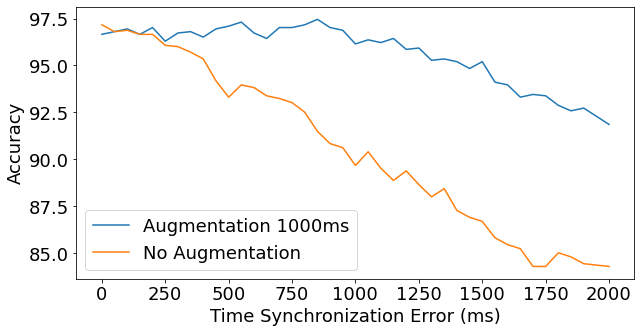

In [38]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 18})

y = np.arange(len(Accuracy_vanilla[:41]))

y = y * 50

plt.plot(y,(np.array(Accuracy_1000ms[:41])*100))
plt.plot(y,(np.array(Accuracy_vanilla[:41])*100))

#plt.title('Fused Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Time Synchronization Error (ms)')
plt.legend(['Augmentation 1000ms','No Augmentation'], loc='lower left')
plt.show()